# Differential Drive Robotics Platform

## Problem Setup

A common robot platform is that of the [differential drive](http://en.wikipedia.org/wiki/Differential_wheeled_robot). The robot is propelled using two wheels, each with their own motor. Usually a caster is used as a third wheel to provide stability. By varying the speeds of the two motors, the robot can change direction.

Differential drive platforms are highly maneuverable, as they have a very small turn radius. They are also extremely simple to design. In this example, the dynamics of a differential drive platform will be explored. The resulting model is highly accurate, but makes a few assumptions:

**Assumptions**

- Wheels roll without slipping
- Body is symmetric

**The setup is as follows:**

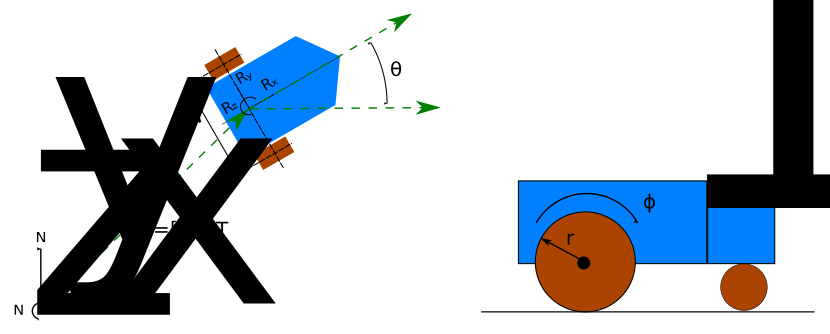

In [1]:
from IPython.display import SVG
SVG(filename='Robot.svg')

## Equations of Motion

We’ll start by generating the equations of motion for the robot with `sympy.physics.mechanics`. The `mechanics` module provides a clean, intuitive workflow for deriving the equations of motion for multibody dynamic systems using either `KanesMethod` or `LagrangesMethod` objects. In this example we'll make use of the `LagrangesMethod` object, which generates the equations of motion using [Lagrangian Mechanics](http://en.wikipedia.org/wiki/Lagrangian_mechanics) with constraints and generalized forces. 

First we import the necessary functionality from SymPy.

In [2]:
from sympy.physics.mechanics import *
from sympy import sin, cos, symbols, Matrix, solve

In [3]:
init_vprinting()

Next we need to define an inertial reference frame, as well as a coordinate origin. All coordinates and reference frames defined later will be in reference to the world coordinate frame.

In [4]:
# Inertial Reference Frame
N = ReferenceFrame('N')

# Define a world coordinate origin
O = Point('O')
O.set_vel(N, 0)

Lagrange's Method requires a state vector $\vec{q}$ that contains all the generalized coordinates required to define the system in space. In the case of the robot:

$$
\vec{q} = [\matrix{x && y && \theta && \phi_1 && \phi_2}]^T
$$

As these are all time varying variables, they need to be created as `dynamicsymbols`:

In [5]:
theta = dynamicsymbols('theta')                      # Rotation about N.z
x, y = dynamicsymbols('x, y')                        # Coordinates of robot in World Frame
phi1, phi2 = dynamicsymbols('phi_1, phi_2')          # Angular displacement of wheel

# Create q and dq vectors
q = Matrix([x, y, theta, phi1, phi2])
dq = q.diff()

We'll also define some constant parameters that define the specific robot:

In [6]:
# Constants for the wheels
r = symbols('r')                                     # Radius of wheel
m_w = symbols('m_w')                                 # Mass of the wheel
t_w = symbols('t_w')                                 # Thickness of the wheel

# Constants for the Robot Body
w = symbols('w')                                     # 2*w is the width of the wheel base
d = symbols('d')                                     # Distance between axel and center of mass
m_b = symbols('m_b')                                 # Mass of the body
Ixx, Iyy, Izz = symbols('Ixx, Iyy, Izz')             # Moments of inertia of body

Next we need to define a reference frame relative to the robot, and a point located at the center of the wheel axis. This will define the robot's location in the world coordinate frame. The velocity of this point is just the derivative of its x and y coordinates.

In [7]:
# Robot Reference Frame
R = N.orientnew('R', 'Axis', [theta, N.z])

# Center of wheel base
Cw = O.locatenew('Cw', x*N.x + y*N.y)

# Set the velocity of point Cw
Cw.set_vel(N, x.diff()*N.x + y.diff()*N.y)

Coordinates of the 2 wheel hubs then need to be specified. To do this we can use the `locatenew` method. The hubs 1 and 2 are located at $-w\vec{R_y}$ and $w\vec{R_y}$ away from the center of the wheel base $C_w$ respectively.

The velocity of the hubs is then found using the `v2pt_theory` method, which calculates the velocity of a point based off the velocity of another point in the same frame, and the angular velocity of that frame ([reference](http://en.wikipedia.org/wiki/Rotating_reference_frame#Relation_between_velocities_in_the_two_frames)).

In [8]:
# Points at wheel hubs
H1 = Cw.locatenew('H1', -w*R.y)
H2 = Cw.locatenew('H2', w*R.y)

# Set the velocity of points H1 and H2
H1.v2pt_theory(Cw, N, R)
H2.v2pt_theory(Cw, N, R);

Rotating reference frames fixed to each wheel are then created. These rotate about the $\vec{R_y}$ axis with the angular position of the wheels, $\phi_1$ and $\phi_2$.

In [9]:
# Create reference frames for wheels 1 and 2
W1 = R.orientnew('W1', 'Axis', [phi1, R.y])
W2 = R.orientnew('W2', 'Axis', [phi2, R.y])

`sympy.physics.mechanics` provides classes for rigid bodies. These make calculating the lagrangian of a multibody system easier, as each body can be handled separately. To do this, each body needs the following things specified:

- A name
- A center of mass
- A reference frame
- A mass
- A tuple of (Inertia, Point of rotation)

Modeling the wheels as solid cylinders, the inertia can be calculated about the hubs, and `RigidBody` objects can be created for each wheel.

In [10]:
# Calculate inertia of the wheel
Iw = inertia(R, m_w*(3*r**2 + t_w**2)/12, m_w*r**2/2, m_w*(3*r**2 + t_w**2)/12)

# Create rigid bodies for wheels
Wheel1 = RigidBody('Wheel1', H1, W1, m_w, (Iw, H1))
Wheel2 = RigidBody('Wheel2', H2, W2, m_w, (Iw, H2))

The same can be done for the body of the robot. In this case we model the body as a symmetric object with inertias $I_{xx}$, $I_{yy}$, and $I_{zz}$. The center of mass of the body is located a distance $d$ in front of the wheel axel.

In [11]:
# Calculate inertia of body
Ib = inertia(R, Ixx, Iyy, Izz)

# Center of mass of body
Cm = Cw.locatenew('Cm', d*R.x)
Cm.v2pt_theory(Cw, N, R)

# Create a rigid body object for body
Body = RigidBody('Body', Cm, R, m_b, (Ib, Cm))

## Nonholonomic Constraints
At this point, the Lagrangian of the system can be calculated. However, the system still isn't fully defined; the constraints still need to be specificed.

At any instance in time, the velocity of the ground contact points must have a velocity of zero. To specify this in the Lagrange equations, a constraint matrix needs to be created.

First, two points are created where the wheels contact the ground, and their velocities calculated.

In [12]:
# Create two points, where the wheels contact the ground
C1 = H1.locatenew('C1', -r*R.z)
C2 = H2.locatenew('C2', -r*R.z)
# Calculate velocity of points
C1.v2pt_theory(H1, N, W1)
C2.v2pt_theory(H2, N, W2);

Using these velocities, a system of equations can be created. As the velocities must be zero, this expression = 0.

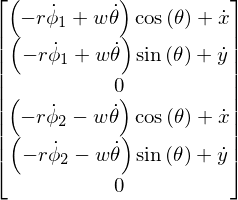

In [13]:
# Express the velocity of points in the inertial frame
con1 = C1.vel(N).express(N).args[0][0]
con2 = C2.vel(N).express(N).args[0][0]
# Create a matrix of constraints
constraints = con1.col_join(con2)
constraints

Since there are 6 equations with 3 unknowns ($\dot{x}$, $\dot{y}$, and $\dot{\theta}$), there are duplicate equations. Using solve, and reconfiguring the expression, this can be reduced to the required set:

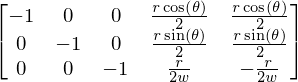

In [14]:
# Solve for dx, dy, and dtheta in terms of dphi1 and dphi2
sol = solve(constraints, dq[:3])

# Split the resulting dict into a rhs and lhs, that are equivalent
sol_rhs = Matrix(list(sol.values()))
sol_lhs = Matrix(list(sol.keys()))

# Since sol_rhs = sol_lhs --> sol_rhs - sol_lhs = 0
# This forms the basis of our constraint matrix.
# Combining, and solving for a linear representation:
c = (sol_rhs - sol_lhs).jacobian(dq[:5])
c

This is our constraint matrix. The `LagrangesMethod` class requires that the constraints be specified as

`coneqs` = $ C\dot{\vec{q}} = 0 $

Thus:

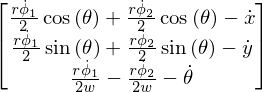

In [15]:
# Constraint Equations
coneqs = (c*dq)
coneqs

## Generalized Forces

The inputs of system are the torques at the wheels. Using the right-hand-rule, it can be seen that a positive torque will exert force on the system in the $R_x$ direction. With a wheel radius of $r$, the force on the wheel hubs is:

$\vec{F_{hub}} = \tau*\vec{R_x}$

In [16]:
# Define forces on system:
T1, T2 = symbols('tau_1, tau_2')              # Torques from the wheels
fl = [(H1, T1/r*R.x),
      (H2, T2/r*R.x)]

## Solving the System Dynamics

We are now ready to solve the for the equations of motion. First, calculate the Lagrangian of the system $L = T - V$:

In [17]:
Lag = Lagrangian(N, Wheel1, Wheel2, Body)

Next, a `LagrangesMethod` object is created. This takes the following parameters:

- The system Lagrangian
- The generalized coordinate vector $\vec{q}$
- The constraint equations
- A list force tuples: (Point, Force at point)
- An inertial reference frame

In [18]:
lm = LagrangesMethod(Lag, q, nonhol_coneqs=coneqs, forcelist=fl, frame=N)

The equations of motion can then be found:

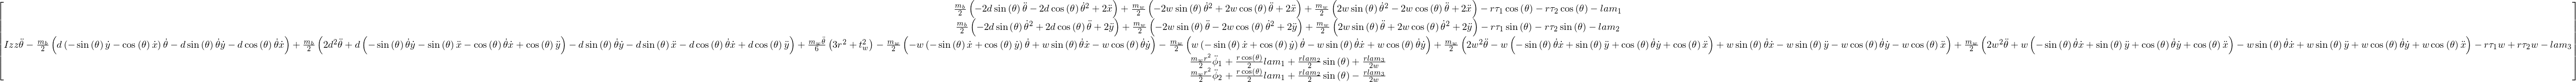

In [19]:
le = lm.form_lagranges_equations()
le

## Simulation

To gain insight into the system dynamics, numerical simulation will be used. First, we need to import a few more functions:

In [20]:
from sympy import lambdify, Dummy
from sympy.physics.mechanics import msubs
from scipy import array, hstack, linspace, ones
from scipy import random, interp, vstack
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

The vector $\ddot{\vec{q}}$ can be calculated in a closed form expression using the `rhs` method. This method takes quite a long time to solve entirely symbolically (it took over an hour on my machine), so a simplifying assumption will be made: $d = 0$. This is actually pretty reasonable, as the motors and battery will be the heaviest part, and should be situated around the axle.

In [21]:
# Solve for the rhs:
rhs = lm.rhs()

# Substitute in d = 0
rhs = msubs(rhs, {d: 0})

We're almost done, all we need to do is model the dynamics of the motor. In general, we can model the current dynamics of the motor as follows:

$$
\dot{i} = -K/L \dot{\phi} - R/L i + V/L
$$

$$
\tau = K i
$$

where $i$ and $V$ are the current and voltage through the motor, $K$ is the motor constant, $R$ is the coil resistance, and $L$ is the coil inductance. Creating this model in sympy is fairly straightforward:

In [22]:
# Create dynamic symbols for current and voltage
i_1, i_2 = dynamicsymbols('i_1, i_2')        # Currents through motor 1 and 2
V_1, V_2 = symbols('V_1, V_2')               # Voltages across the motor terminals

# Define some motor constants.
# Assuming motor 1 and 2 are the same:
R = symbols('R')                             # Coil resistance
L = symbols('L')                             # Coil inductance
K1, K2 = symbols('K1, K2')                   # Motor constant

# Define the motor dynamics
di = Matrix([[-K1/L*phi1.diff() - R/L*i_1 + V_1/L],
             [-K2/L*phi2.diff() - R/L*i_2 + V_2/L]])

Now we just need to combine the motor model with the model for the robot:

In [23]:
# Define consts:
params = [Izz,  t_w,  m_w,    r,  m_b,   w,    R,      L,   K1,  K2]
values = [  5, 0.15,  2.0, 0.15, 50.0, 0.6, 0.05, 0.0001,  1.0, 1.0]       # Values of constants

# Create a list of dynamic symbols for simulation
dynamics = q.T.tolist()[0] + dq.T.tolist()[0] + lm.lam_vec.T.tolist()[0] + [i_1, i_2]

# Set the inputs to be the motor voltages
inputs = [V_1, V_2]

# Add the motor model to the rhs equations
aug_rhs = rhs.col_join(di)

# Substitute in K*i for T in the rhs equations
aug_rhs = aug_rhs.subs({T1: K1*i_1, T2: K2*i_2})

Currently the codegen functionality provided by `PyDy` doesn't support equations with Lagrange Multipliers (this is planned for future releases). For now `lambdify` can be used to convert the expression into a function to solve the rhs based on the current state and inputs.

In [24]:
# Create a list of dynamic symbols for simulation
dummys = [Dummy() for i in dynamics]
dummydict = dict(zip(dynamics, dummys))
# Sub in the dummy symbols
rhs_dummy = msubs(aug_rhs, dummydict)
# Lambdify function
rhs_func = lambdify(dummys + inputs + params, rhs_dummy, modules='numpy')

In [25]:
# Create a function in the required format for odeint
def right_hand_side(x, t, ts, us, values):
    """Calculate the rhs of the integral, at
    time t, state x.
    ts, us are used to get the current input
    values are constants in the integral"""
    
    # Interp is needed to get u for timestep
    u1 = interp(t, ts, us[:,0])
    u2 = interp(t, ts, us[:,1])
    
    arguments = hstack((x, u1, u2, values))
    
    # Need call to array and reshape, as odeint
    # requires state vector to be 1d
    dx = array(rhs_func(*arguments))
    return dx.reshape(dx.size)

Now we have everything we need to simulate the motion. First, let's see what happens if we input a constant, unbalanced voltage signal. Motor 1 gets 24 volts, Motor 2 gets 20 volts. Intuitively, this should cause the robot to drive in a circle.

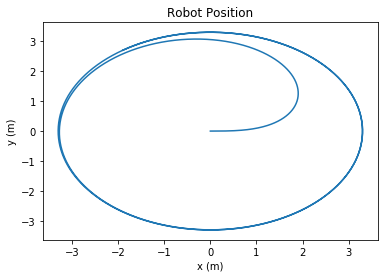

In [26]:
ts = linspace(0, 30, 3000)
us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
# Run the simulation
x0 = [0,] * 15                         # Start out at origin, unmoving
xs = odeint(right_hand_side, x0, ts, args=(ts, us, values))

plt.plot(xs[:,0], xs[:,1])
plt.title('Robot Position')
plt.xlabel('x (m)')
plt.ylabel('y (m)');

As seen by the simulation, the results line up with our intuition. The reason it doesn't immediately start out in a circle is due to the time it takes for it to accelerate from rest.

If we were designing such a platform, we might want to see the effects different design parameters have on the motion. Because the solution is symbolic, it's easy to experiment. Here we'll see what having a heavier body and larger inertia do to the motion:

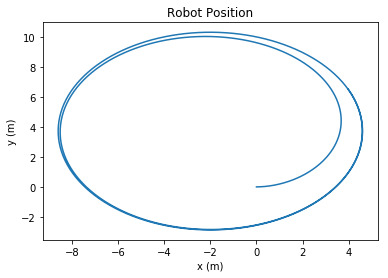

In [27]:
ts = linspace(0, 30, 1000)
us = vstack((24*ones(len(ts)), 20*ones(len(ts)))).T
# Body is twice as heavy, with twice as much rotational inertia
values = [  10, 0.15,  2.0, 0.15, 100.0, 0.6, 0.05, 0.0001,  1.0, 1.0]       # Values of constants
# Run the simulation
x0 = [0,] * 15                         # Start out at origin, unmoving
xs = odeint(right_hand_side, x0, ts, args=(ts, us, values))
plt.plot(xs[:,0], xs[:,1])
plt.title('Robot Position')
plt.xlabel('x (m)')
plt.ylabel('y (m)');